In [1]:
import torch
import torch.nn as nn
from collections import Counter
import pandas as pd
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
import numpy as np

from sklearn import svm
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import matplotlib
import seaborn as sns
from sklearn.metrics import confusion_matrix

import sys
import os

In [2]:
# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "decision_trees"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [3]:
# to make this notebook's output stable across runs
np.random.seed(42)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
def data_input(n):  # n 参数代表取n行作为训练集
    file_path = '/content/drive/My Drive/processed_data.csv'
    data = pd.read_csv(file_path, encoding="unicode_escape")
    data = data.sample(frac=1).reset_index(drop=True) # 打乱顺序
    # print(data)

    # 数据原本是str形式，这里我把前十行转成int如果要整列转 有NAN 需要数据处理后实现data["generated"] = data["generated"].astype(int)
    data.iloc[0:n, 1] = data.iloc[0:n, 1].astype(int)
    y = torch.tensor(data.iloc[0:n, 1], dtype=torch.float32)
    texts = []
    for i in range(n):
        texts.append(data.iloc[i, 0])

    # 构建词汇表(每个词出现的次数)
    word_counts = Counter()
    for text in texts:
        word_counts.update(str(text).lower().split())

    # 创建词典（每个单词对应一个index）
    word2idx = {
        word: idx + 1 for idx, (word, _) in enumerate(word_counts.most_common())
    }
    word2idx["<unk>"] = 0  # 未知词标记

    # 将文本转换为索引序列
    indexed_texts = [
        [word2idx.get(word, 0) for word in str(text).lower().split()] for text in texts
    ]

    # 将文本填充为相同长度
    input = pad_sequence(
        [torch.tensor(text, dtype=torch.long) for text in indexed_texts],
        batch_first=True,
    )
    return input, word2idx, y

In [6]:
def embedding(input, word2idx, embedding_dim=100):
    num_embeddings = len(word2idx)
    # num_embeddings:入层字典的大小（单词本里单词个数）
    # embedding_dim: 每个产出向量的大小
    embedding = nn.Embedding(num_embeddings, embedding_dim)
    inputs = embedding(input)
    inputs = torch.mean(inputs, dim=1)
    return inputs

In [7]:
def multihead_attention(input_tensor):
    # 设置输入维度和注意力头数
    input_dim = input_tensor.size(-1)
    num_heads = 4  # 注意embedding_dim要可以整除num_heads
    assert input_dim % num_heads == 0, "embed_dim must be divisible by num_heads"
    # 实例化 MultiheadAttention 模块
    attention = nn.MultiheadAttention(embed_dim=input_dim, num_heads=num_heads)
    # 对输入进行自注意力计算
    attention_output, _ = attention(input_tensor, input_tensor, input_tensor)
    return attention_output

In [8]:
def Logistic_Regression(matrix_x_train, matrix_x_test, matrix_y_train, matrix_y_test):
    classifier = LogisticRegression()
    classifier.fit(matrix_x_train, matrix_y_train)
    pred_tr_y=classifier.predict(matrix_x_train)
    pred_y = classifier.predict(matrix_x_test)

    return accuracy_score(
        matrix_y_train, classifier.predict(matrix_x_train)
    ), accuracy_score(matrix_y_test, classifier.predict(matrix_x_test)),pred_tr_y, pred_y

In [9]:
def KNN(matrix_x_train, matrix_x_test, matrix_y_train, matrix_y_test, n_neighbors=5):
    classifier = KNeighborsClassifier(n_neighbors)
    classifier.fit(matrix_x_train, matrix_y_train)
    pred_tr_y=classifier.predict(matrix_x_train)
    pred_y = classifier.predict(matrix_x_test)

    return accuracy_score(
        matrix_y_train, classifier.predict(matrix_x_train)
    ), accuracy_score(matrix_y_test, classifier.predict(matrix_x_test)),pred_tr_y, pred_y

In [10]:
def randomforest(
    matrix_x_train, matrix_x_test, matrix_y_train, matrix_y_test, n_estimators=100,max_depth=10
):
    classifier = RandomForestClassifier(n_estimators,max_depth=max_depth)
    classifier.fit(matrix_x_train, matrix_y_train)
    # 提取一个决策树
    #estimator = classifier.estimators_[5]
    pred_tr_y=classifier.predict(matrix_x_train)
    pred_y=classifier.predict(matrix_x_test)
    return accuracy_score(
        matrix_y_train, classifier.predict(matrix_x_train)
    ), accuracy_score(matrix_y_test, classifier.predict(matrix_x_test)), pred_tr_y, pred_y

In [11]:
max_depth_list=[5,10,15,20]
embedding_dim = 500
rf_tr_Accuracy_list=[]
rf_tr_Recall_list=[]
rf_tr_F1_list=[]
rf_te_Accuracy_list=[]
rf_te_Recall_list=[]
rf_te_F1_list=[]
for depth in max_depth_list:
  print("tree depth=",depth)
  n_samples=5000
  print('n_samples=',n_samples)
  train_n = n_samples
  test_n = n_samples
  X_train, word2idx_train, y_train = data_input(train_n)
  X_trains = embedding(X_train, word2idx_train, embedding_dim)

  X_test, word2idx_test, y_test = data_input(test_n)
  X_tests = embedding(X_test, word2idx_test, embedding_dim)
  attention_X_train = multihead_attention(X_trains)
  attention_X_test = multihead_attention(X_tests)

  matrix_x_train = np.asarray(attention_X_train.detach().numpy())
  matrix_x_test = np.asarray(attention_X_test.detach().numpy())
  matrix_y_train = np.asarray(y_train.detach().numpy()).T
  matrix_y_test = np.asarray(y_test.detach().numpy()).T

  tr_rf = 0
  te_rf = 0
  rf_tr_Accuracy=0
  rf_tr_Recall=0
  rf_tr_F1=0
  rf_te_Accuracy=0
  rf_te_Recall=0
  rf_te_F1=0

  n_splits = 5
  # k-folder
  kfold = KFold(n_splits=5, shuffle=True, random_state=42)

  # 迭代划分数据集并进行交叉验证
  for train_index, test_index in kfold.split(matrix_x_train):

    # 划分训练集和测试集
    train_x, test_x = matrix_x_train[train_index], matrix_x_train[test_index]
    train_y, test_y = matrix_y_train[train_index], matrix_y_train[test_index]

    e, f,randomforest_trpred_y, randomforest_pred_y = randomforest(train_x, test_x, train_y, test_y, n_estimators=100,max_depth=depth)
    #tr_rf += e
    #te_rf += f
    cm = confusion_matrix(train_y,randomforest_trpred_y)
    #cm_normalised = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    #rf_tr_Accuracy +=(cm_normalised[0][0]+cm_normalised[1][1])/(cm_normalised[0][0]+cm_normalised[1][1]+cm_normalised[0][1]+cm_normalised[1][0])
    rf_tr_Accuracy +=(cm[0][0]+cm[1][1])/(cm[0][0]+cm[1][1]+cm[0][1]+cm[1][0])
    rf_tr_Recall +=(cm[0][0])/(cm[0][0]+cm[0][1])
    rf_tr_F1 += (2*cm[0][0])/(2*cm[0][0]+cm[0][1]+cm[1][0])

    cm = confusion_matrix(test_y,randomforest_pred_y)
    #cm_normalised = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    #rf_te_Accuracy +=(cm_normalised[0][0]+cm_normalised[1][1])/(cm_normalised[0][0]+cm_normalised[1][1]+cm_normalised[0][1]+cm_normalised[1][0])
    rf_te_Accuracy +=(cm[0][0]+cm[1][1])/(cm[0][0]+cm[1][1]+cm[0][1]+cm[1][0])
    rf_te_Recall +=(cm[0][0])/(cm[0][0]+cm[0][1])
    rf_te_F1 += (2*cm[0][0])/(2*cm[0][0]+cm[0][1]+cm[1][0])

  print("For the random forest classifier")
  #print("Train Accuracy:", tr_rf / n_splits)
  #print("Test Accuracy:", te_rf / n_splits)
  print("Confusion matrix Train accuracy:",rf_tr_Accuracy/n_splits)
  print("Recall:",rf_tr_Recall/n_splits)
  print("F1:",rf_tr_F1/n_splits)
  rf_tr_Accuracy_list.append(rf_tr_Accuracy/n_splits)
  rf_tr_Recall_list.append(rf_tr_Recall/n_splits)
  rf_tr_F1_list.append(rf_tr_F1/n_splits)
  print("Confusion matrix Test accuracy:",rf_te_Accuracy/n_splits)
  print("Recall:",rf_te_Recall/n_splits)
  print("F1:",rf_te_F1/n_splits)
  rf_te_Accuracy_list.append(rf_te_Accuracy/n_splits)
  rf_te_Recall_list.append(rf_te_Recall/n_splits)
  rf_te_F1_list.append(rf_te_F1/n_splits)

print("For the random forest classifier")
print(rf_tr_Accuracy_list)
print(rf_tr_Recall_list)
print(rf_tr_F1_list)
print(rf_te_Accuracy_list)
print(rf_te_Recall_list)
print(rf_te_F1_list)


tree depth= 5
n_samples= 5000
For the random forest classifier
Confusion matrix Train accuracy: 0.7637
Recall: 0.8544715238317115
F1: 0.8133031282617885
Confusion matrix Test accuracy: 0.7228
Recall: 0.8239570242578284
F1: 0.7816608585462943
tree depth= 10
n_samples= 5000
For the random forest classifier
Confusion matrix Train accuracy: 0.87095
Recall: 0.9432014408641229
F1: 0.8983896351478391
Confusion matrix Test accuracy: 0.6881999999999999
Recall: 0.810237612670415
F1: 0.7585943390614104
tree depth= 15
n_samples= 5000
For the random forest classifier
Confusion matrix Train accuracy: 0.99145
Recall: 0.9945182425710672
F1: 0.9929156169440148
Confusion matrix Test accuracy: 0.6836
Recall: 0.7942484672684108
F1: 0.7510626708365112
tree depth= 20
n_samples= 5000
For the random forest classifier
Confusion matrix Train accuracy: 0.9999500000000001
Recall: 1.0
F1: 0.9999583940087373
Confusion matrix Test accuracy: 0.6746000000000001
Recall: 0.7857959070571503
F1: 0.7433592357451944
For the

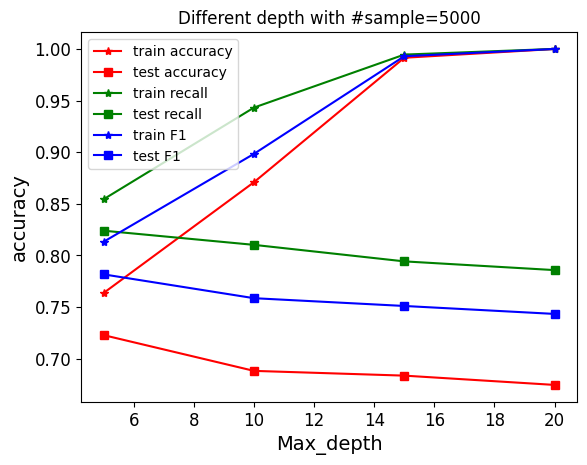

In [12]:
x=max_depth_list
plt.figure(1)
plt.xlabel("Max_depth")#横坐标名字
plt.ylabel("accuracy")#纵坐标名字
plt.title('Different depth with #sample='+str(n_samples))
plt.plot(x,rf_tr_Accuracy_list,'*-',color = 'r',label="train accuracy")#s-:方形
plt.plot(x,rf_te_Accuracy_list,'s-',color = 'r',label="test accuracy")#o-:圆形
plt.plot(x,rf_tr_Recall_list,'*-',color = 'g',label="train recall")
plt.plot(x,rf_te_Recall_list,'s-',color = 'g',label="test recall")
plt.plot(x,rf_tr_F1_list,'*-',color = 'b',label="train F1")
plt.plot(x,rf_te_F1_list,'s-',color = 'b',label="test F1")
plt.legend(loc ='best')
plt.savefig('DiffDepth.jpg')
plt.show()

In [15]:
def stacking(matrix_x_train, matrix_x_test, matrix_y_train, matrix_y_test):
    rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
    knn_clf = KNeighborsClassifier()

    stacking_clf = StackingClassifier(estimators=[("rf", rf_clf), ("knn", knn_clf)])
    stacking_clf.fit(matrix_x_train, matrix_y_train)
    pred_tr_y=stacking_clf.predict(matrix_x_train)
    pred_y=stacking_clf.predict(matrix_x_test)

    return accuracy_score(
        matrix_y_train, stacking_clf.predict(matrix_x_train)
    ), accuracy_score(matrix_y_test, stacking_clf.predict(matrix_x_test)), pred_tr_y, pred_y

In [16]:
embedding_dim = 500

LR_tr_Accuracy_list=[]
LR_tr_Recall_list=[]
LR_tr_F1_list=[]
LR_te_Accuracy_list=[]
LR_te_Recall_list=[]
LR_te_F1_list=[]

rf_tr_Accuracy_list=[]
rf_tr_Recall_list=[]
rf_tr_F1_list=[]
rf_te_Accuracy_list=[]
rf_te_Recall_list=[]
rf_te_F1_list=[]

knn_tr_Accuracy_list=[]
knn_tr_Recall_list=[]
knn_tr_F1_list=[]
knn_te_Accuracy_list=[]
knn_te_Recall_list=[]
knn_te_F1_list=[]

st_tr_Accuracy_list=[]
st_tr_Recall_list=[]
st_tr_F1_list=[]
st_te_Accuracy_list=[]
st_te_Recall_list=[]
st_te_F1_list=[]

n_samples_list=[100,500,1000,1500,2000, 3000, 5000]
for n_samples in n_samples_list:
  print('n_samples=',n_samples)
  train_n = n_samples
  test_n = n_samples
  X_train, word2idx_train, y_train = data_input(train_n)
  X_trains = embedding(X_train, word2idx_train, embedding_dim)

  X_test, word2idx_test, y_test = data_input(test_n)
  X_tests = embedding(X_test, word2idx_test, embedding_dim)
  attention_X_train = multihead_attention(X_trains)
  attention_X_test = multihead_attention(X_tests)

  matrix_x_train = np.asarray(attention_X_train.detach().numpy())
  matrix_x_test = np.asarray(attention_X_test.detach().numpy())
  matrix_y_train = np.asarray(y_train.detach().numpy()).T
  matrix_y_test = np.asarray(y_test.detach().numpy()).T



  tr_LR = 0
  te_LR = 0
  LR_tr_Accuracy=0
  LR_tr_Recall=0
  LR_tr_F1=0
  LR_te_Accuracy=0
  LR_te_Recall=0
  LR_te_F1=0

  tr_rf = 0
  te_rf = 0
  rf_tr_Accuracy=0
  rf_tr_Recall=0
  rf_tr_F1=0
  rf_te_Accuracy=0
  rf_te_Recall=0
  rf_te_F1=0

  tr_knn = 0
  te_knn = 0
  knn_tr_Accuracy=0
  knn_tr_Recall=0
  knn_tr_F1=0
  knn_te_Accuracy=0
  knn_te_Recall=0
  knn_te_F1=0

  tr_st = 0
  te_st = 0
  st_tr_Accuracy=0
  st_tr_Recall=0
  st_tr_F1=0
  st_te_Accuracy=0
  st_te_Recall=0
  st_te_F1=0

  n_splits = 5

  # k-folder
  kfold = KFold(n_splits=5, shuffle=True, random_state=42)

  # 迭代划分数据集并进行交叉验证
  for train_index, test_index in kfold.split(matrix_x_train):

      # 划分训练集和测试集
      train_x, test_x = matrix_x_train[train_index], matrix_x_train[test_index]
      train_y, test_y = matrix_y_train[train_index], matrix_y_train[test_index]

      # 分别对每个分类器进行训练和评估
      a, b,Logistic_Regression_trpred_y, Logistic_Regression_pred_y = Logistic_Regression(train_x, test_x, train_y, test_y)
      cm = confusion_matrix(train_y,Logistic_Regression_trpred_y)
      LR_tr_Accuracy +=(cm[0][0]+cm[1][1])/(cm[0][0]+cm[1][1]+cm[0][1]+cm[1][0])
      LR_tr_Recall +=(cm[0][0])/(cm[0][0]+cm[0][1])
      LR_tr_F1 += (2*cm[0][0])/(2*cm[0][0]+cm[0][1]+cm[1][0])

      cm = confusion_matrix(test_y,Logistic_Regression_pred_y)
      LR_te_Accuracy +=(cm[0][0]+cm[1][1])/(cm[0][0]+cm[1][1]+cm[0][1]+cm[1][0])
      LR_te_Recall +=(cm[0][0])/(cm[0][0]+cm[0][1])
      LR_te_F1 += (2*cm[0][0])/(2*cm[0][0]+cm[0][1]+cm[1][0])

      c, d,KNN_trpred_y, KNN_pred_y = KNN(train_x, test_x, train_y, test_y, n_neighbors=5)
      cm = confusion_matrix(train_y,KNN_trpred_y)
      knn_tr_Accuracy +=(cm[0][0]+cm[1][1])/(cm[0][0]+cm[1][1]+cm[0][1]+cm[1][0])
      knn_tr_Recall +=(cm[0][0])/(cm[0][0]+cm[0][1])
      knn_tr_F1 += (2*cm[0][0])/(2*cm[0][0]+cm[0][1]+cm[1][0])

      cm = confusion_matrix(test_y,KNN_pred_y)
      knn_te_Accuracy +=(cm[0][0]+cm[1][1])/(cm[0][0]+cm[1][1]+cm[0][1]+cm[1][0])
      knn_te_Recall +=(cm[0][0])/(cm[0][0]+cm[0][1])
      knn_te_F1 += (2*cm[0][0])/(2*cm[0][0]+cm[0][1]+cm[1][0])

      e, f,randomforest_trpred_y, randomforest_pred_y = randomforest(train_x, test_x, train_y, test_y, n_estimators=100)
      cm = confusion_matrix(train_y,randomforest_trpred_y)
      rf_tr_Accuracy +=(cm[0][0]+cm[1][1])/(cm[0][0]+cm[1][1]+cm[0][1]+cm[1][0])
      rf_tr_Recall +=(cm[0][0])/(cm[0][0]+cm[0][1])
      rf_tr_F1 += (2*cm[0][0])/(2*cm[0][0]+cm[0][1]+cm[1][0])

      cm = confusion_matrix(test_y,randomforest_pred_y)
      rf_te_Accuracy +=(cm[0][0]+cm[1][1])/(cm[0][0]+cm[1][1]+cm[0][1]+cm[1][0])
      rf_te_Recall +=(cm[0][0])/(cm[0][0]+cm[0][1])
      rf_te_F1 += (2*cm[0][0])/(2*cm[0][0]+cm[0][1]+cm[1][0])

      g, h,stacking_trpred_y, stacking_pred_y = stacking(train_x, test_x, train_y, test_y)
      cm = confusion_matrix(train_y,stacking_trpred_y)
      st_tr_Accuracy +=(cm[0][0]+cm[1][1])/(cm[0][0]+cm[1][1]+cm[0][1]+cm[1][0])
      st_tr_Recall +=(cm[0][0])/(cm[0][0]+cm[0][1])
      st_tr_F1 += (2*cm[0][0])/(2*cm[0][0]+cm[0][1]+cm[1][0])

      cm = confusion_matrix(test_y,stacking_pred_y)
      st_te_Accuracy +=(cm[0][0]+cm[1][1])/(cm[0][0]+cm[1][1]+cm[0][1]+cm[1][0])
      st_te_Recall +=(cm[0][0])/(cm[0][0]+cm[0][1])
      st_te_F1 += (2*cm[0][0])/(2*cm[0][0]+cm[0][1]+cm[1][0])

  print("For the LR classifier")
  print("Confusion matrix Train accuracy:",LR_tr_Accuracy/n_splits)
  print("Recall:",LR_tr_Recall/n_splits)
  print("F1:",LR_tr_F1/n_splits)
  LR_tr_Accuracy_list.append(LR_tr_Accuracy/n_splits)
  LR_tr_Recall_list.append(LR_tr_Recall/n_splits)
  LR_tr_F1_list.append(LR_tr_F1/n_splits)
  print("Confusion matrix Test accuracy:",LR_te_Accuracy/n_splits)
  print("Recall:",LR_te_Recall/n_splits)
  print("F1:",LR_te_F1/n_splits)
  LR_te_Accuracy_list.append(LR_te_Accuracy/n_splits)
  LR_te_Recall_list.append(LR_te_Recall/n_splits)
  LR_te_F1_list.append(LR_te_F1/n_splits)

  print("For the KNN classifier")
  print("Confusion matrix Train accuracy:",knn_tr_Accuracy/n_splits)
  print("Recall:",knn_tr_Recall/n_splits)
  print("F1:",knn_tr_F1/n_splits)
  knn_tr_Accuracy_list.append(knn_tr_Accuracy/n_splits)
  knn_tr_Recall_list.append(knn_tr_Recall/n_splits)
  knn_tr_F1_list.append(knn_tr_F1/n_splits)
  print("Confusion matrix Test accuracy:",knn_te_Accuracy/n_splits)
  print("Recall:",knn_te_Recall/n_splits)
  print("F1:",knn_te_F1/n_splits)
  knn_te_Accuracy_list.append(knn_te_Accuracy/n_splits)
  knn_te_Recall_list.append(knn_te_Recall/n_splits)
  knn_te_F1_list.append(knn_te_F1/n_splits)

  print("For the random forest classifier")
  print("Confusion matrix Train accuracy:",rf_tr_Accuracy/n_splits)
  print("Recall:",rf_tr_Recall/n_splits)
  print("F1:",rf_tr_F1/n_splits)
  rf_tr_Accuracy_list.append(rf_tr_Accuracy/n_splits)
  rf_tr_Recall_list.append(rf_tr_Recall/n_splits)
  rf_tr_F1_list.append(rf_tr_F1/n_splits)
  print("Confusion matrix Test accuracy:",rf_te_Accuracy/n_splits)
  print("Recall:",rf_te_Recall/n_splits)
  print("F1:",rf_te_F1/n_splits)
  rf_te_Accuracy_list.append(rf_te_Accuracy/n_splits)
  rf_te_Recall_list.append(rf_te_Recall/n_splits)
  rf_te_F1_list.append(rf_te_F1/n_splits)

  print("For the Stacking classifier:")
  print("Confusion matrix Train accuracy:",st_tr_Accuracy/n_splits)
  print("Recall:",st_tr_Recall/n_splits)
  print("F1:",st_tr_F1/n_splits)
  st_tr_Accuracy_list.append(st_tr_Accuracy/n_splits)
  st_tr_Recall_list.append(st_tr_Recall/n_splits)
  st_tr_F1_list.append(st_tr_F1/n_splits)
  print("Confusion matrix Test accuracy:",st_te_Accuracy/n_splits)
  print("Recall:",st_te_Recall/n_splits)
  print("F1:",st_te_F1/n_splits)
  st_te_Accuracy_list.append(st_te_Accuracy/n_splits)
  st_te_Recall_list.append(st_te_Recall/n_splits)
  st_te_F1_list.append(st_te_F1/n_splits)

print("For the SVM classifier")
print(LR_tr_Accuracy_list)
print(LR_tr_Recall_list)
print(LR_tr_F1_list)
print(LR_te_Accuracy_list)
print(LR_te_Recall_list)
print(LR_te_F1_list)

print("For the KNN classifier")
print(knn_tr_Accuracy_list)
print(knn_tr_Recall_list)
print(knn_tr_F1_list)
print(knn_te_Accuracy_list)
print(knn_te_Recall_list)
print(knn_te_F1_list)

print("For the random forest classifier")
print(rf_tr_Accuracy_list)
print(rf_tr_Recall_list)
print(rf_tr_F1_list)
print(rf_te_Accuracy_list)
print(rf_te_Recall_list)
print(rf_te_F1_list)

print("For the Stacking classifier:")
print(st_tr_Accuracy_list)
print(st_tr_Recall_list)
print(st_tr_F1_list)
print(st_te_Accuracy_list)
print(st_te_Recall_list)
print(st_te_F1_list)

n_samples= 100
For the LR classifier
Confusion matrix Train accuracy: 0.7
Recall: 1.0
F1: 0.8233003159612954
Confusion matrix Test accuracy: 0.7
Recall: 1.0
F1: 0.819836914713575
For the KNN classifier
Confusion matrix Train accuracy: 0.8400000000000001
Recall: 0.9354504545662206
F1: 0.8910075849081108
Confusion matrix Test accuracy: 0.76
Recall: 0.9061879297173416
F1: 0.8421941946484063
For the random forest classifier
Confusion matrix Train accuracy: 1.0
Recall: 1.0
F1: 1.0
Confusion matrix Test accuracy: 0.7699999999999999
Recall: 0.851642475171887
F1: 0.8294086021505376
For the Stacking classifier:
Confusion matrix Train accuracy: 0.8975000000000002
Recall: 1.0
F1: 0.9320479036167711
Confusion matrix Test accuracy: 0.75
Recall: 0.9440030557677617
F1: 0.8378091231981175
n_samples= 500
For the LR classifier
Confusion matrix Train accuracy: 0.596
Recall: 1.0
F1: 0.7468503703410698
Confusion matrix Test accuracy: 0.596
Recall: 1.0
F1: 0.7466038900895338
For the KNN classifier
Confusion

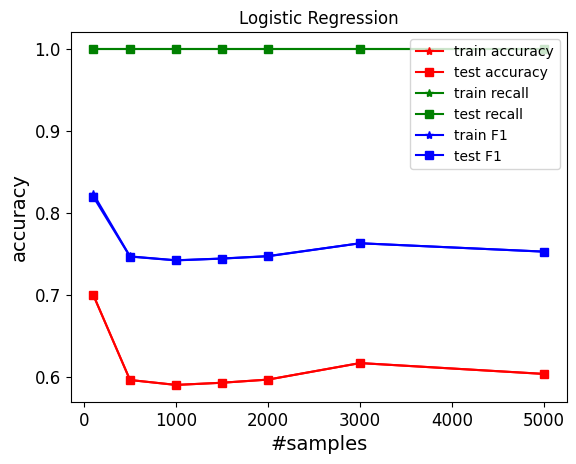

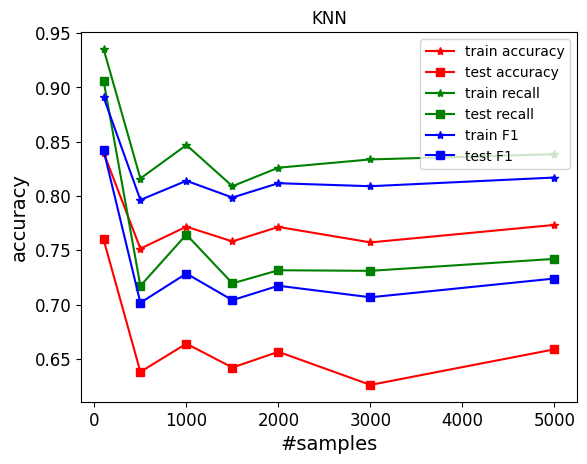

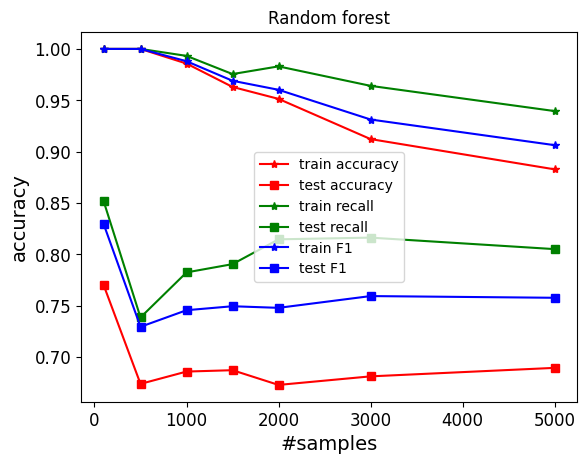

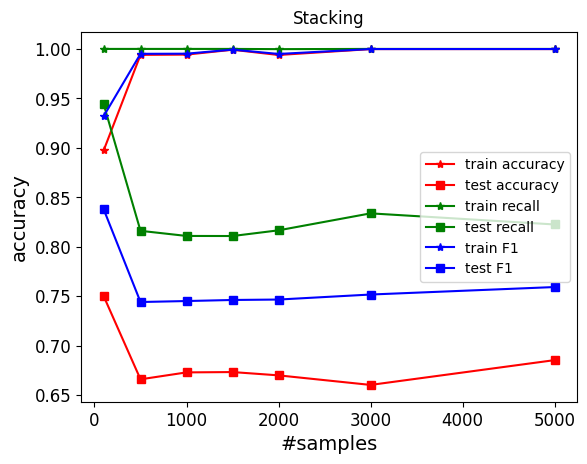

In [17]:
x=n_samples_list
plt.figure(1)
plt.xlabel("#samples")#横坐标名字
plt.ylabel("accuracy")#纵坐标名字
plt.title('Logistic Regression')
plt.plot(x,LR_tr_Accuracy_list,'*-',color = 'r',label="train accuracy")#s-:方形
plt.plot(x,LR_te_Accuracy_list,'s-',color = 'r',label="test accuracy")#o-:圆形
plt.plot(x,LR_tr_Recall_list,'*-',color = 'g',label="train recall")
plt.plot(x,LR_te_Recall_list,'s-',color = 'g',label="test recall")
plt.plot(x,LR_tr_F1_list,'*-',color = 'b',label="train F1")
plt.plot(x,LR_te_F1_list,'s-',color = 'b',label="test F1")
plt.legend(loc ='best')
plt.savefig('LR.jpg')

plt.figure(2)
plt.xlabel("#samples")#横坐标名字
plt.ylabel("accuracy")#纵坐标名字
plt.title('KNN')
plt.plot(x,knn_tr_Accuracy_list,'*-',color = 'r',label="train accuracy")#s-:方形
plt.plot(x,knn_te_Accuracy_list,'s-',color = 'r',label="test accuracy")#o-:圆形
plt.plot(x,knn_tr_Recall_list,'*-',color = 'g',label="train recall")
plt.plot(x,knn_te_Recall_list,'s-',color = 'g',label="test recall")
plt.plot(x,knn_tr_F1_list,'*-',color = 'b',label="train F1")
plt.plot(x,knn_te_F1_list,'s-',color = 'b',label="test F1")
plt.legend(loc = "best")#图例
plt.savefig('KNN.jpg')

plt.figure(3)
plt.xlabel("#samples")#横坐标名字
plt.ylabel("accuracy")#纵坐标名字
plt.title('Random forest')
plt.plot(x,rf_tr_Accuracy_list,'*-',color = 'r',label="train accuracy")#s-:方形
plt.plot(x,rf_te_Accuracy_list,'s-',color = 'r',label="test accuracy")#o-:圆形
plt.plot(x,rf_tr_Recall_list,'*-',color = 'g',label="train recall")
plt.plot(x,rf_te_Recall_list,'s-',color = 'g',label="test recall")
plt.plot(x,rf_tr_F1_list,'*-',color = 'b',label="train F1")
plt.plot(x,rf_te_F1_list,'s-',color = 'b',label="test F1")
plt.legend(loc = "best")#图例
plt.savefig('RF.jpg')

plt.figure(4)
plt.xlabel("#samples")#横坐标名字
plt.ylabel("accuracy")#纵坐标名字
plt.title('Stacking')
plt.plot(x,st_tr_Accuracy_list,'*-',color = 'r',label="train accuracy")#s-:方形
plt.plot(x,st_te_Accuracy_list,'s-',color = 'r',label="test accuracy")#o-:圆形
plt.plot(x,st_tr_Recall_list,'*-',color = 'g',label="train recall")
plt.plot(x,st_te_Recall_list,'s-',color = 'g',label="test recall")
plt.plot(x,st_tr_F1_list,'*-',color = 'b',label="train F1")
plt.plot(x,st_te_F1_list,'s-',color = 'b',label="test F1")
plt.legend(loc = "best")#图例
plt.savefig('ST.jpg')
plt.show()